Extract transect across image <br>
Make this into a python function at some point

In [1]:
# import stuff
import os,sys
import glob
import pandas
from osgeo import gdal
import datetime 
from datetime import datetime
from datetime import timedelta
from dateutil import parser
import numpy as np
from scipy.ndimage import uniform_filter, gaussian_filter
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib  widget

In [2]:
workdir = '/data/ocp4/LagunaSalada/'
#cropdir='cropped_9000_20_10000_1780/'
cropdir='cropped_9000_1800_18000_3600/'

dates = [os.path.basename(x) for x in glob.glob(workdir+cropdir+"SLC_vv/2*")]
dates=sorted(dates)
#print(str(len(dates))+' dates so far!')
nd=len(dates)

In [3]:
# load single igram
date1='20190112'
date2='20190124'

x0=0; dx=18000; y0=0; dy=3600 # changes with different subregion
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", \
               gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(x0,y0,dx,dy)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", \
               gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(x0,y0,dx,dy)
int12 = slc1 * np.conj(slc2)

In [4]:
# define the points you want the transect to be between
startx=9234; starty=1345
endx=10000; endy=1500

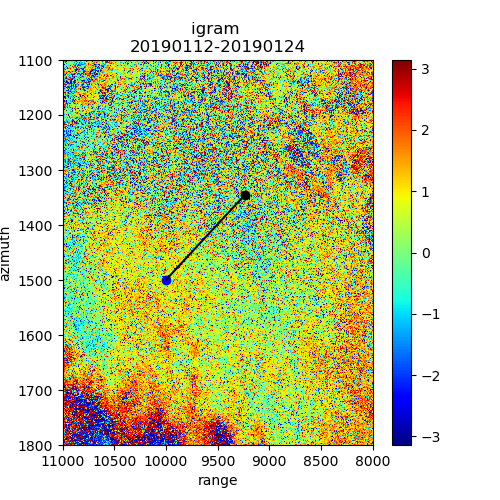

In [5]:
# now plot it spatially 
plt.figure(figsize=(5, 5))
plt.imshow(np.angle(int12),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='auto', \
           interpolation='nearest')
plt.ylabel('azimuth')
plt.xlabel('range')
plt.title("igram \n"+str(date1)+"-"+str(date2))
plt.colorbar()
plt.xlim(dx, 0)
plt.plot(startx,starty,'ko')
plt.plot(endx,endy,'bo')
line1=([startx,endx],[starty,endy])
plt.plot(line1[0],line1[1],'k-')
# Zoomed in 
plt.xlim([11000,8000])
plt.ylim([1800,1100])
# plot rectangle over area we will extract
plt.show()

In [125]:
# Calculate the angle that we need to rotate the points 
theta = np.arctan((endy-starty)/(endx-startx))
#theta = theta*180/np.pi # converting to degrees
print(theta)

0.19965402526970427


In [126]:
# design the rotation matrix
rot = np.zeros((2,2),'float')
rot[0] = [np.cos(theta),-np.sin(theta)]
rot[1] = [np.sin(theta),np.cos(theta)]
print(rot)

[[ 0.98013525 -0.19833024]
 [ 0.19833024  0.98013525]]


In [112]:
print('extracted box range length: '+str(endx-startx))
print('(width)')
print('extracted box azimuth length: '+str(endy-starty))
print('(height)')

extracted box range length: 766
(width)
extracted box azimuth length: 155
(height)


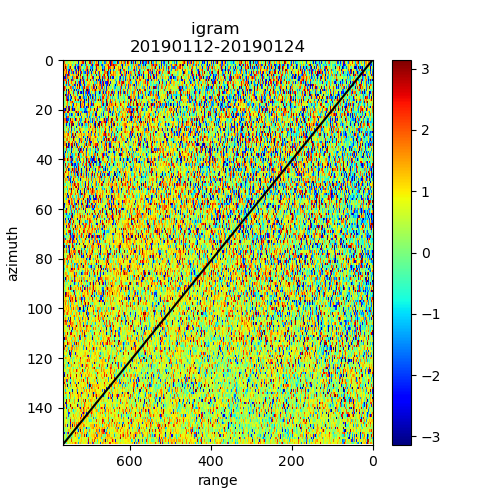

In [113]:
# Extract the data in the box that includes the transect 
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date1+"/"+date1+".slc.full", \
               gdal.GA_ReadOnly)
slc1 = ds.GetRasterBand(1).ReadAsArray(startx,starty,endx-startx,endy-starty)
ds = gdal.Open(workdir+"/"+cropdir+"/SLC_vv/"+date2+"/"+date2+".slc.full", \
               gdal.GA_ReadOnly)
slc2 = ds.GetRasterBand(1).ReadAsArray(startx,starty,endx-startx,endy-starty)
int12 = slc1 * np.conj(slc2)

plt.figure(figsize=(5, 5))
plt.imshow(np.angle(int12),vmin=-np.pi, vmax=np.pi, cmap='jet', aspect='auto', \
           interpolation='nearest')
plt.ylabel('azimuth'); plt.xlabel('range')
plt.title("igram \n"+str(date1)+"-"+str(date2))
plt.colorbar()
#plt.plot(startx,starty,'ko')
#plt.plot(endx,endy,'bo')
line1=([0,endx-startx],[0,endy-starty])
plt.plot(line1[0],line1[1],'k-')
# Zoomed in 
plt.xlim([endx-startx,0])
plt.ylim([endy-starty,0])
plt.show()

In [129]:
print(np.shape(int12))

(155, 766)


In [165]:
# make a meshgrid for defining coordinates of the centers of pixels 
x = np.arange(0.5,endx-startx,1)
y = np.arange(0.5,endy-starty,1)
grdx,grdy = np.meshgrid(x,y,indexing='xy')

print(endx-startx)
print(endy-starty)
#print(x[0:10])
#print(y[-10:-1])
print(np.shape(grdy))
#print(grd[1])
#print(255*766)
print(type(grdx))
grdx1 = grdx.reshape(1,118730)
grdy1 = grdy.reshape(1,118730)
grd = np.vstack((grdx1,grdy1))  
print(np.shape(grd))

766
155
(155, 766)
<class 'numpy.ndarray'>
(2, 118730)


In [115]:
# New (startx,starty) (endx, endy) points are moved over
startx1 = 0; starty1 = 0; endx1 = endx-startx; endy1 = endy-starty

In [130]:
# make array of distances off of the line for each pixel 
distsOffTsct = np.ndarray([endy-starty, endx-startx],'float')

# loop through rows and columns and calculate distance off the line  
for i in np.arange(0,endx-startx):
    for j in np.arange(0,endy-starty):
        distsOffTsct[j,i] =  (np.abs((endx1-startx1)*(starty1-y[j])- \
                                    (startx1-x[i])*(endy1-starty1))) / \
                                    (np.sqrt(np.square(endx1-startx1)+ \
                                             np.square(endy1-starty1)))

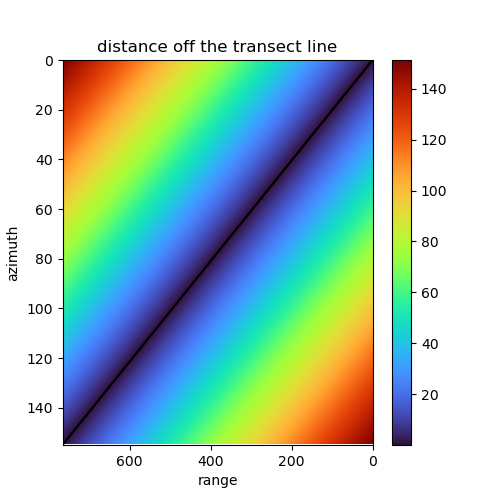

In [131]:
# plot distances off transect 
plt.figure(figsize=(5, 5))
plt.imshow(distsOffTsct, cmap='turbo', aspect='auto')
plt.ylabel('azimuth'); plt.xlabel('range')
plt.title('distance off the transect line')
plt.colorbar()
#plt.plot(startx,starty,'ko')
#plt.plot(endx,endy,'bo')
line1=([0,endx-startx],[0,endy-starty])
plt.plot(line1[0],line1[1],'k-')
plt.xlim([endx-startx,0])
plt.ylim([endy-starty,0])
plt.show()

In [132]:
# how far off of the transect do you want to select pixels for? 
perpDist = 3
# this will average over 10 pixels off transect in BOTH directions (perpendicular) 

# gives the indices where the 
ind = np.where(distsOffTsct < perpDist)
# how many points are within desired distance of transect? 
numPts = len(ind[1])
print(np.shape(ind))
print(numPts)
print(ind[0][-10:-1])
print(ind[1][-10:-1])
print(x[-10:-1])

(2, 4642)
4642
[154 154 154 154 154 154 154 154 154]
[756 757 758 759 760 761 762 763 764]
[756.5 757.5 758.5 759.5 760.5 761.5 762.5 763.5 764.5]


In [119]:
# design the original x,y matrix 
xy = np.zeros((2,numPts),'float')
print(np.shape(xy))
xy = ind

(2, 4642)


In [133]:
# multiply rotation matrix by xy matrix to get new xy matrix
xyPrime = np.matmul(rot,xy)
print(np.shape(xyPrime))

# so now what is this matrix? 
print(xyPrime[1][0:20])
print(xyPrime[0][0:20])

(2, 4642)
[ 0.          0.98013525  1.96027051  2.94040576  3.92054102  4.90067627
  5.88081152  6.86094678  7.84108203  8.82121728  9.80135254 10.78148779
 11.76162305 12.7417583  13.72189355 14.70202881 15.68216406 16.66229931
  0.19833024  1.17846549]
[ 0.         -0.19833024 -0.39666048 -0.59499072 -0.79332096 -0.9916512
 -1.18998144 -1.38831168 -1.58664193 -1.78497217 -1.98330241 -2.18163265
 -2.37996289 -2.57829313 -2.77662337 -2.97495361 -3.17328385 -3.37161409
  0.98013525  0.78180501]


In [171]:
newxy = np.matmul(rot,grd)
print(np.shape(newxy))

#reshape again
x1=newxy[1,:].reshape((155, 766))
print(x1)

(2, 118730)
[[  0.58923275   0.78756299   0.98589323 ... 151.91520636 152.1135366
  152.31186684]
 [  1.569368     1.76769824   1.96602848 ... 152.89534161 153.09367185
  153.29200209]
 [  2.54950325   2.7478335    2.94616374 ... 153.87547686 154.0738071
  154.27213735]
 ...
 [149.56979132 149.76812156 149.9664518  ... 300.89576493 301.09409517
  301.29242541]
 [150.54992657 150.74825681 150.94658705 ... 301.87590018 302.07423042
  302.27256066]
 [151.53006182 151.72839207 151.92672231 ... 302.85603543 303.05436568
  303.25269592]]


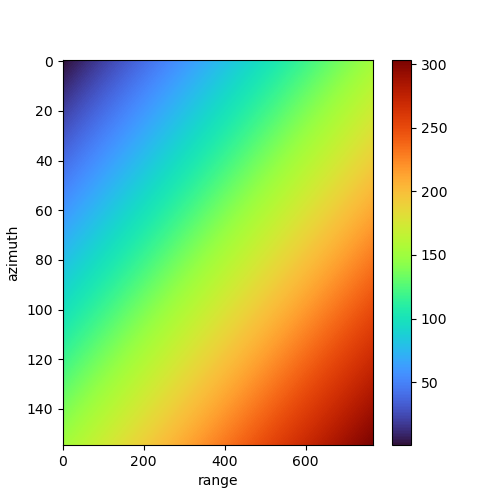

In [172]:
# plot distances off transect 
plt.figure(figsize=(5, 5))
plt.imshow(x1, cmap='turbo', aspect='auto')
plt.ylabel('azimuth'); plt.xlabel('range')
#plt.title('distance off the transect line')
plt.colorbar()
#plt.plot(startx,starty,'ko')
#plt.plot(endx,endy,'bo')
#line1=([0,endx-startx],[0,endy-starty])
#plt.plot(line1[0],line1[1],'k-')
#plt.xlim([endx-startx,0])
#plt.ylim([endy-starty,0])
plt.show()

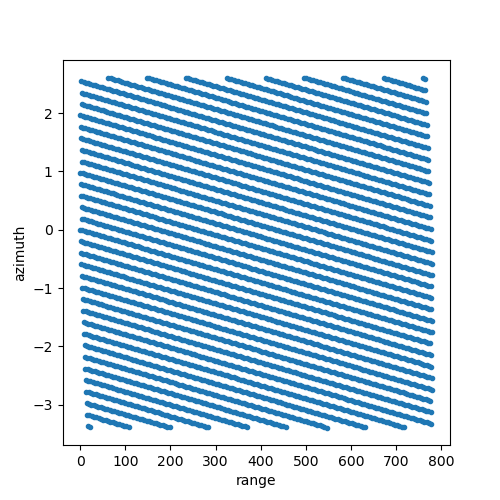

In [134]:
# now the points are rotated
plt.figure(figsize=(5, 5))
plt.plot(xyPrime[1],xyPrime[0],'.')
plt.ylabel('azimuth'); plt.xlabel('range')
#plt.title('distance off the transect line')
#plt.colorbar()
#plt.plot(startx,starty,'ko')
#plt.plot(endx,endy,'bo')
#line1=([0,endx-startx],[0,endy-starty])
#plt.plot(line1[0],line1[1],'k-')
#plt.xlim([endx-startx,0])
#plt.ylim([endy-starty,0])
plt.show()

<br> <br> <br> <br> Everything below is not useful: 

In [22]:
# initialize array for booleans 
isClose = np.ndarray([endx-startx,endy-starty],'bool')

# loop through rows and columns and see if the pixel is close enough to be useful 
for i in np.arange(0,endx-startx):
    for j in np.arange(0,endy-starty):
        
        

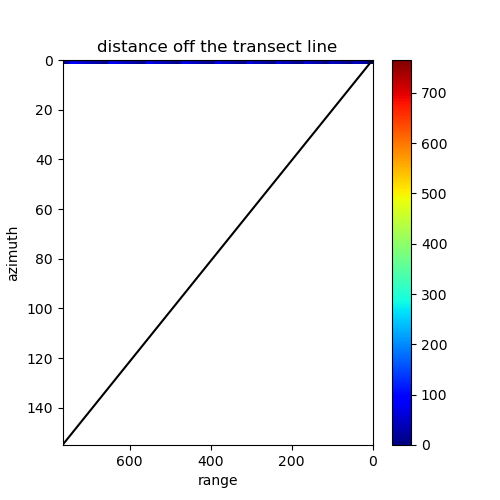

In [68]:
# plot which pixels are within the desired perpDist in black 
plt.figure(figsize=(5, 5))
plt.imshow(ind, cmap='jet', aspect='auto')
plt.ylabel('azimuth'); plt.xlabel('range')
plt.title('distance off the transect line')
plt.colorbar()
#plt.plot(startx,starty,'ko')
#plt.plot(endx,endy,'bo')
line1=([0,endx-startx],[0,endy-starty])
plt.plot(line1[0],line1[1],'k-')
plt.xlim([endx-startx,0])
plt.ylim([endy-starty,0])
plt.show()

In [ ]:
floor 5 